In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
import multiprocessing as mp
from scipy.optimize import curve_fit
import bces.bces as bces
import time
from astropy.io import fits

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
whichch="hfi"
dataset="planck_pr3"

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
figstamp=dataset + "_" + whichch

save_results=False
run_analysis=False

In [3]:
outpath="/results/" + dataset + "/planck_cosmo_cat_" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=True)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() ; xsz_cat=pmmf.xsz_cat

ysz_cat=ymsr.ppd.get_cosmo_catalogue_ysz()
xsz_cat["BIAS"]=np.copy(ysz_cat["BIAS"])
xsz_cat["T500"]=np.copy(xsz_cat["TX"])
xsz_cat["M500"]=np.copy(ysz_cat["M_Yx_500"]/1e14)
xsz_cat["M500_err"]=(ysz_cat['ERRM_M_Yx_500'] + ysz_cat['ERRP_M_Yx_500'])*0.5/1e14
xsz_cat["YSZ_500"]=np.copy(ysz_cat['Y_500'])
xsz_cat["YSZ_500_err"]=np.copy(ysz_cat["ERR_Y_500"])

# Figures for inpainted data

<IPython.core.display.Javascript object>


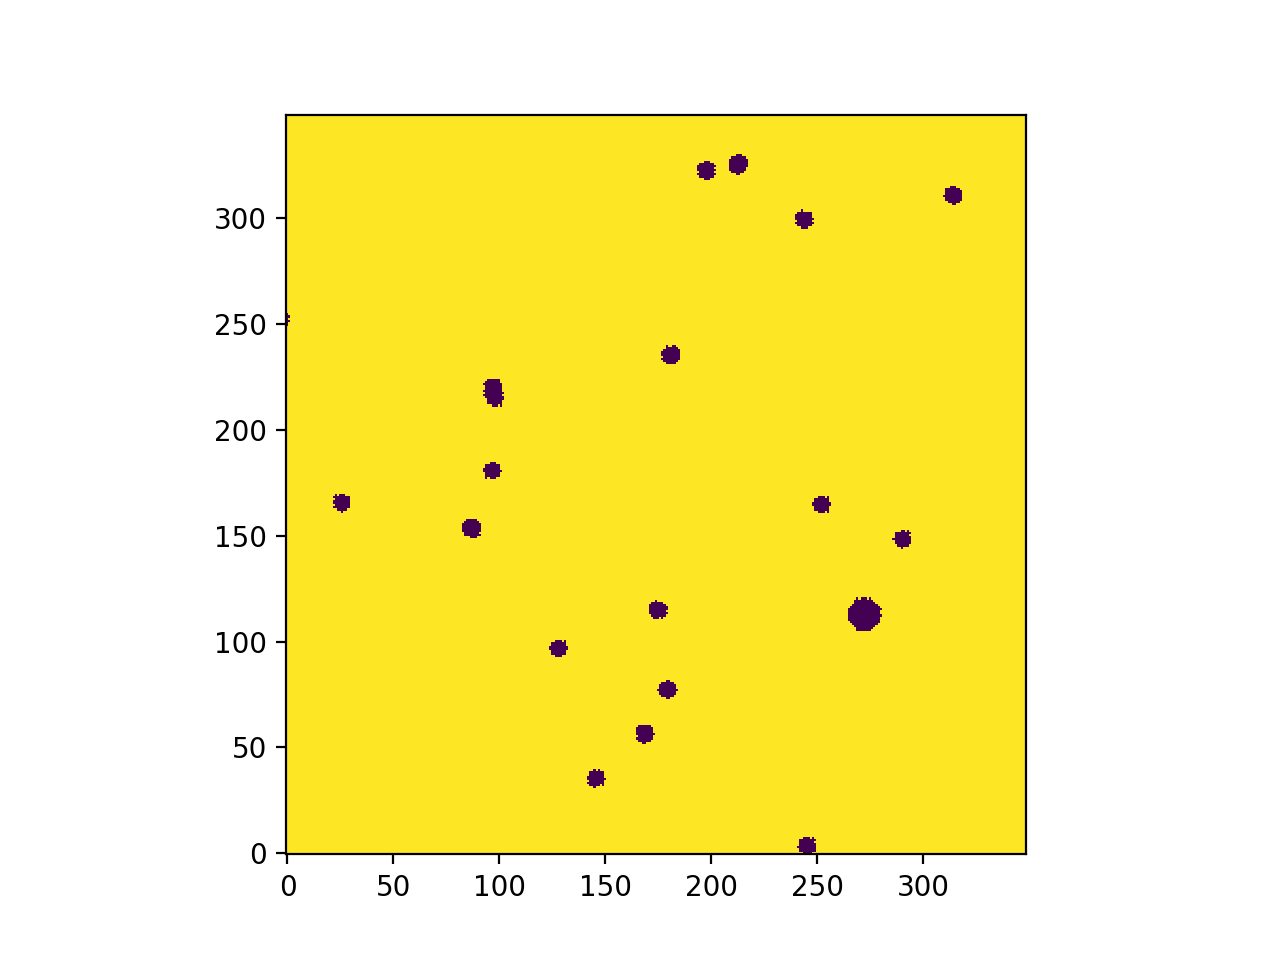

<IPython.core.display.Javascript object>


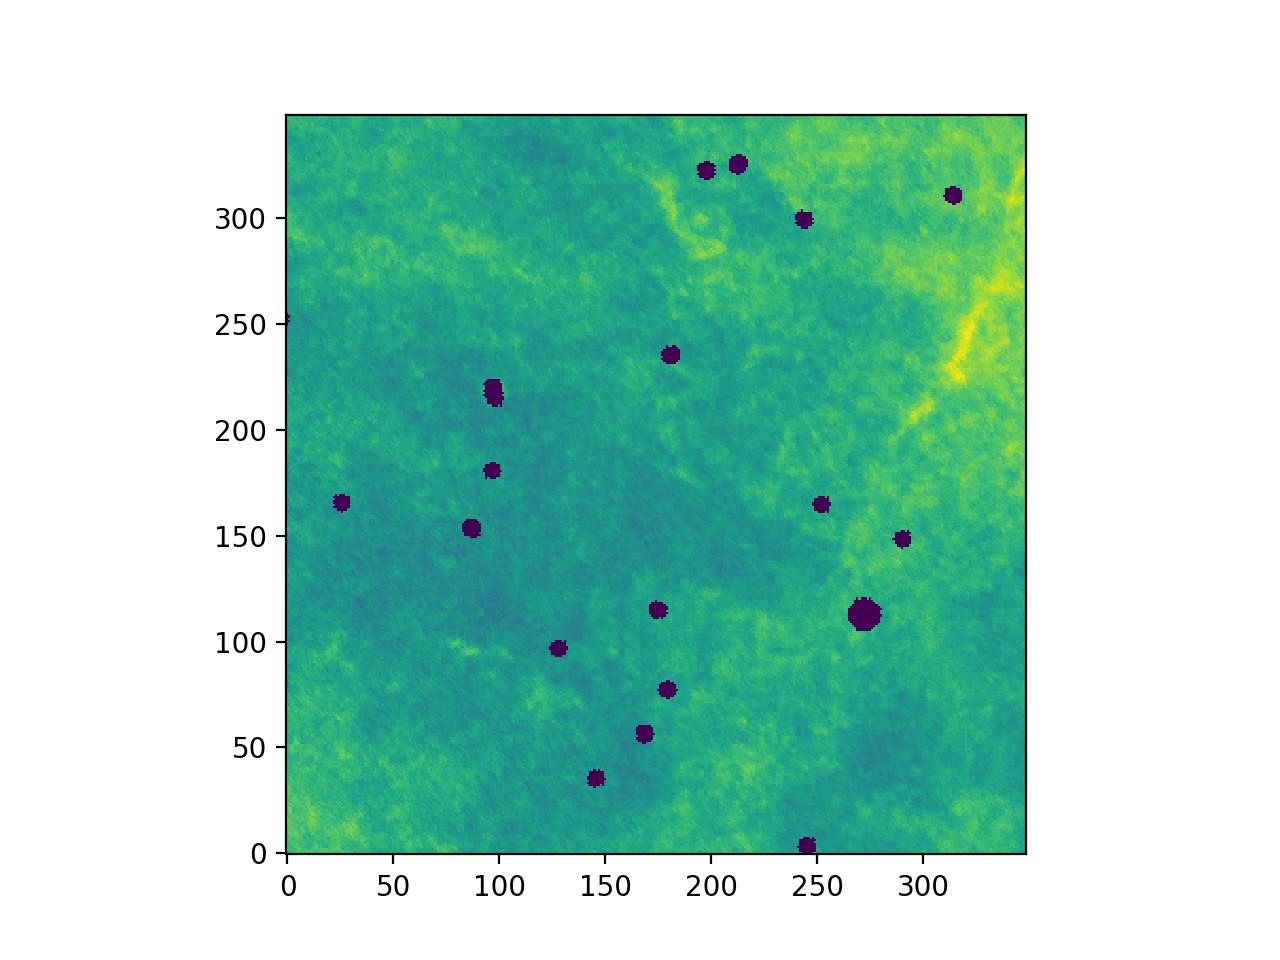

In [41]:
idx=47 ; chidx=7
filename=xsz_cat["FILENAME"][idx]
strlen=len(xsz_cat["FILENAME"][idx])
f1=fits.open(filename)
mask=f1[3].data
data=f1[2].data[chidx,]
ch=f1[1].data[chidx]
ttl=xsz_cat["FILENAME"][idx][strlen-18:strlen-5] + " " + str(int(ch)) + " GHz"
sfx=xsz_cat["FILENAME"][idx][strlen-18:strlen-5] + "_" + str(int(ch)) + "GHz"
figure()
imshow(mask,origin="lower")

figure()
imshow(data*mask,origin="lower")

In [42]:
fdata=ymsr.ppd.paint.return_ps_filled_data(data,mask,pixel_size=gset.mmfset.reso,diffthr=1e-2)

fnames=[]

ioff()
figure()
imshow(data,vmin=min(fdata.ravel()),vmax=max(fdata.ravel()),origin="lower")
#colorbar()
title(ttl)
figname=figpath + "unmasked_data.jpeg"
savefig(figname,bbox_inches="tight")
fnames=np.append(fnames,figname)

# figure()
# imshow(mask,origin="lower")
# #colorbar()
# title(ttl)
# figname=figpath + "ps_mask.jpeg"
# savefig(figname,bbox_inches="tight")
# fnames=np.append(fnames,figname)

figure()
imshow(data*mask,vmin=min(fdata.ravel()),vmax=max(fdata.ravel()),origin="lower")
#colorbar()
title(ttl)
figname=figpath + "ps_masked_data.jpeg"
savefig(figname,bbox_inches="tight")
fnames=np.append(fnames,figname)

figure()
imshow(fdata,vmin=min(fdata.ravel()),vmax=max(fdata.ravel()),origin="lower")
#colorbar()
title(ttl)
figname=figpath + "inpainted_data.jpeg"
savefig(figname,bbox_inches="tight")
fnames=np.append(fnames,figname)

fnameout=figpath + "compare_masked_vs_inpainted_" + sfx + ".gif"
cmd = "convert -loop 0 -delay 200 "
cmd = cmd + fnames[0] + " " + fnames[1] + " " +  fnames[2] + " " + fnameout
os.system(cmd)
cmd = "rm " + fnames[0] + " " + fnames[1] + " " +  fnames[2]
os.system(cmd)
ion()

# Cluster detection with and withour edge apodization

In [4]:
idx=62
ymsr.ppd.gen_ps_inpainted_data(idx)

Filename: /Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//tempdata/planck_pr3/planck_cosmo_cat/10deg_patches//tangent_planes/cluster_G305.87-44.57.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Channels      1 ImageHDU         7   (9,)   float64   
  2  Data tangent plane    1 ImageHDU        13   (349, 349, 9)   float64   
  3  Point Source Mask    1 ImageHDU         8   (349, 349)   float64   
  4  Extended point Source Mask    1 ImageHDU         8   (349, 349)   float64   
  5  PS inpainted data tangent plane    1 ImageHDU         9   (349, 349, 9)   float64   


<IPython.core.display.Javascript object>


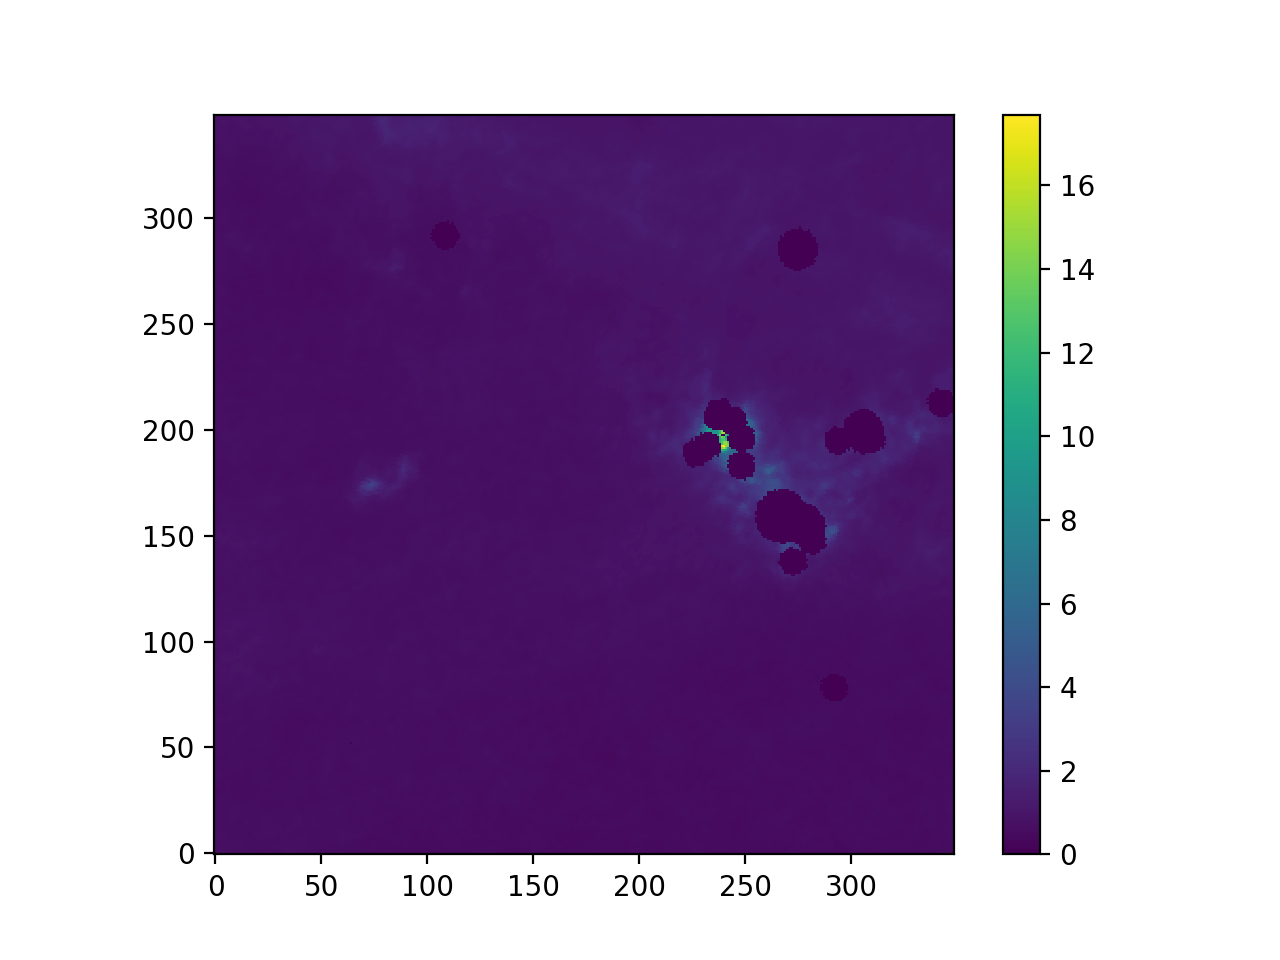

<IPython.core.display.Javascript object>


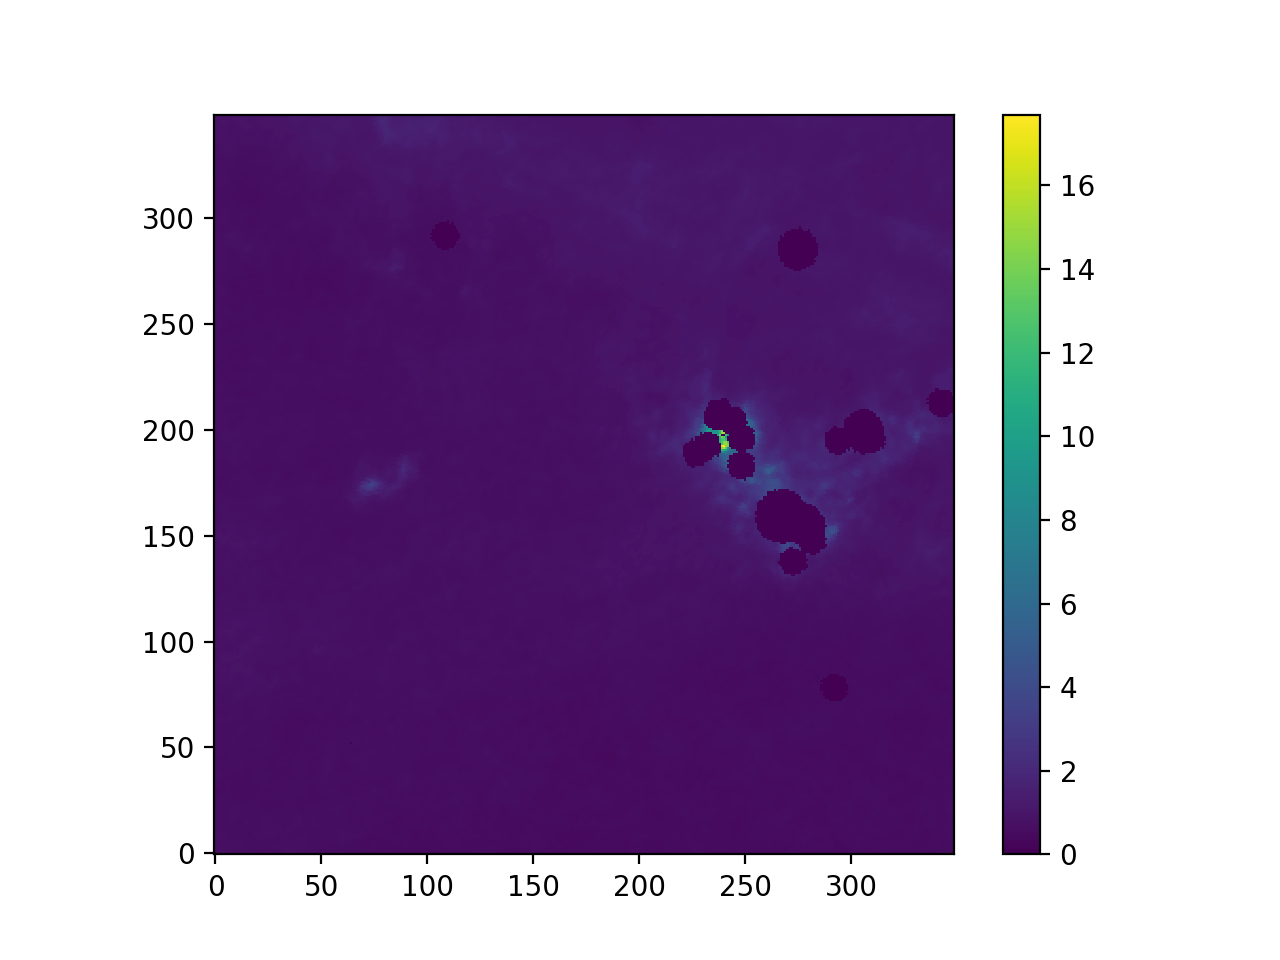

In [9]:
filename=xsz_cat["FILENAME"][idx]
f1=fits.open(filename)
f1.info()

figure()
imshow(f1[5].data[8,]*f1[4].data,origin="lower")
colorbar()

figure()
imshow(f1[2].data[8,]*f1[4].data,origin="lower")
colorbar()

f1.close()

0.000112376639946 1.79540861377e-05


<IPython.core.display.Javascript object>


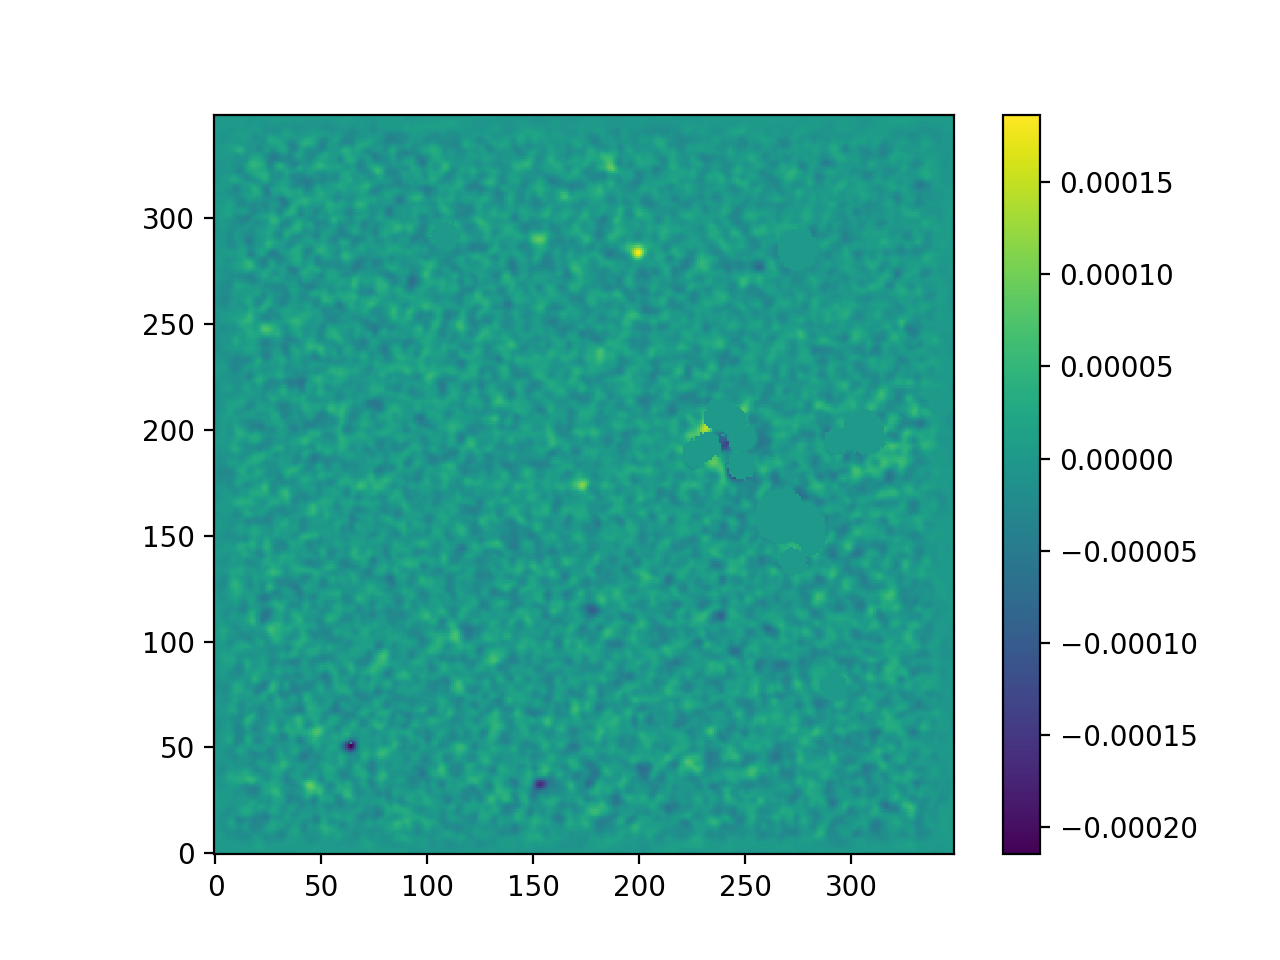

<IPython.core.display.Javascript object>


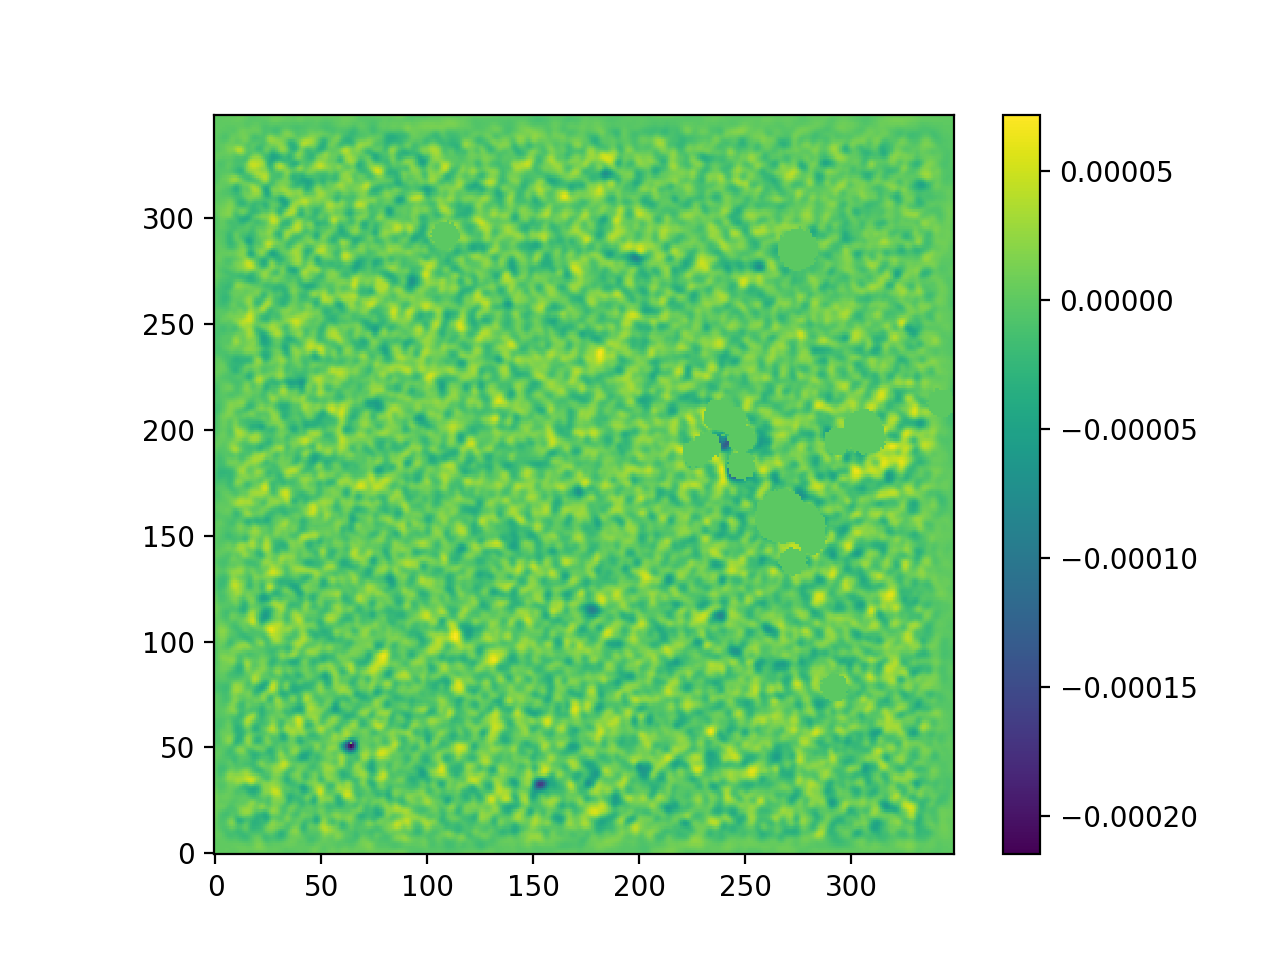

<IPython.core.display.Javascript object>


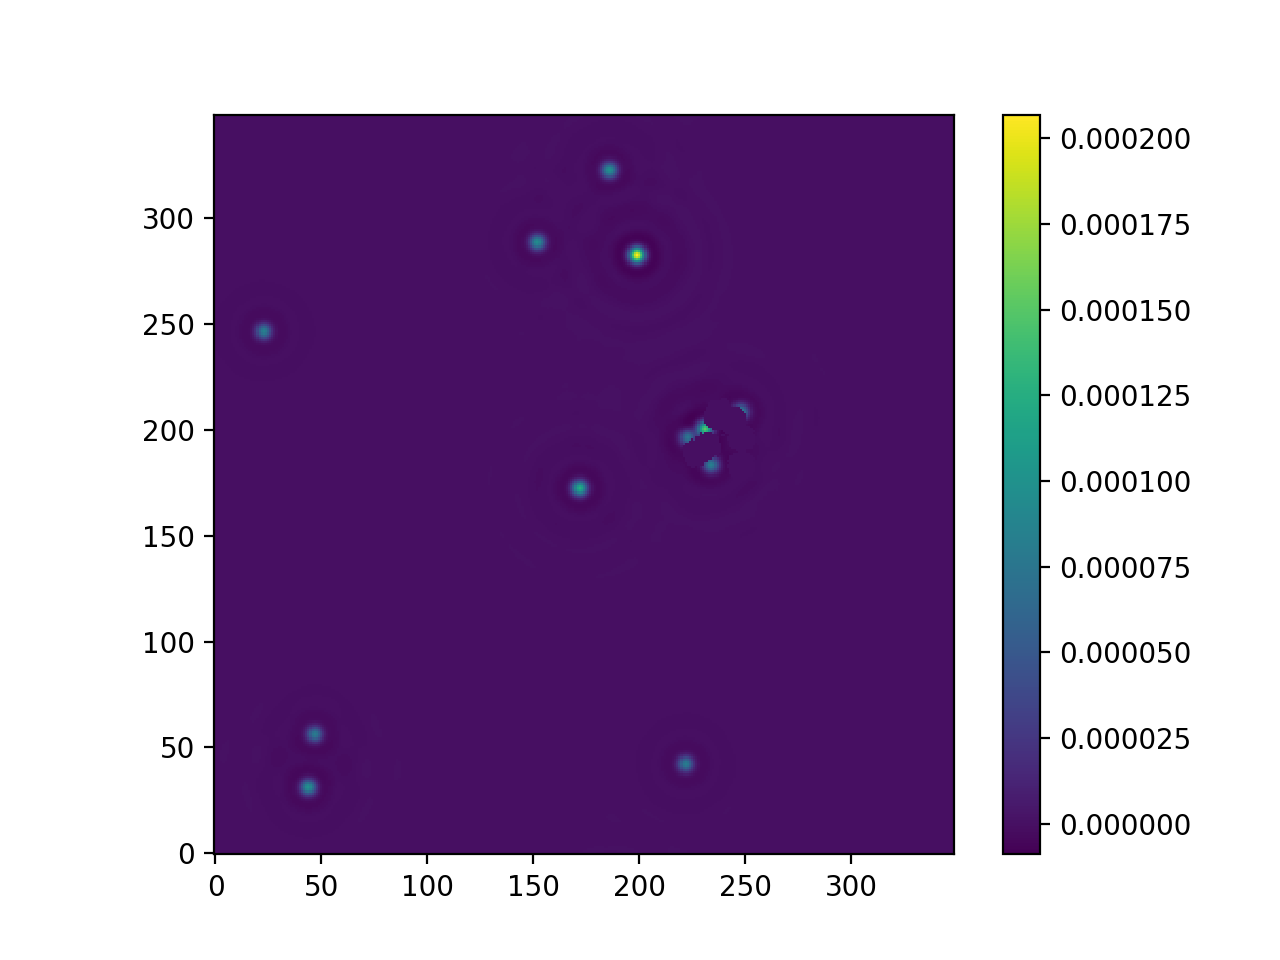

In [7]:
pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

filename=xsz_cat["FILENAME"][idx]
mask=ymsr.gtp.return_ext_ps_mask(filename)

figure()
imshow(fdata*mask,origin="lower")
colorbar()

figure()
imshow(fdatar*mask,origin="lower")
colorbar()

figure()
imshow((fdata-fdatar)*mask,origin="lower")
colorbar()

<IPython.core.display.Javascript object>


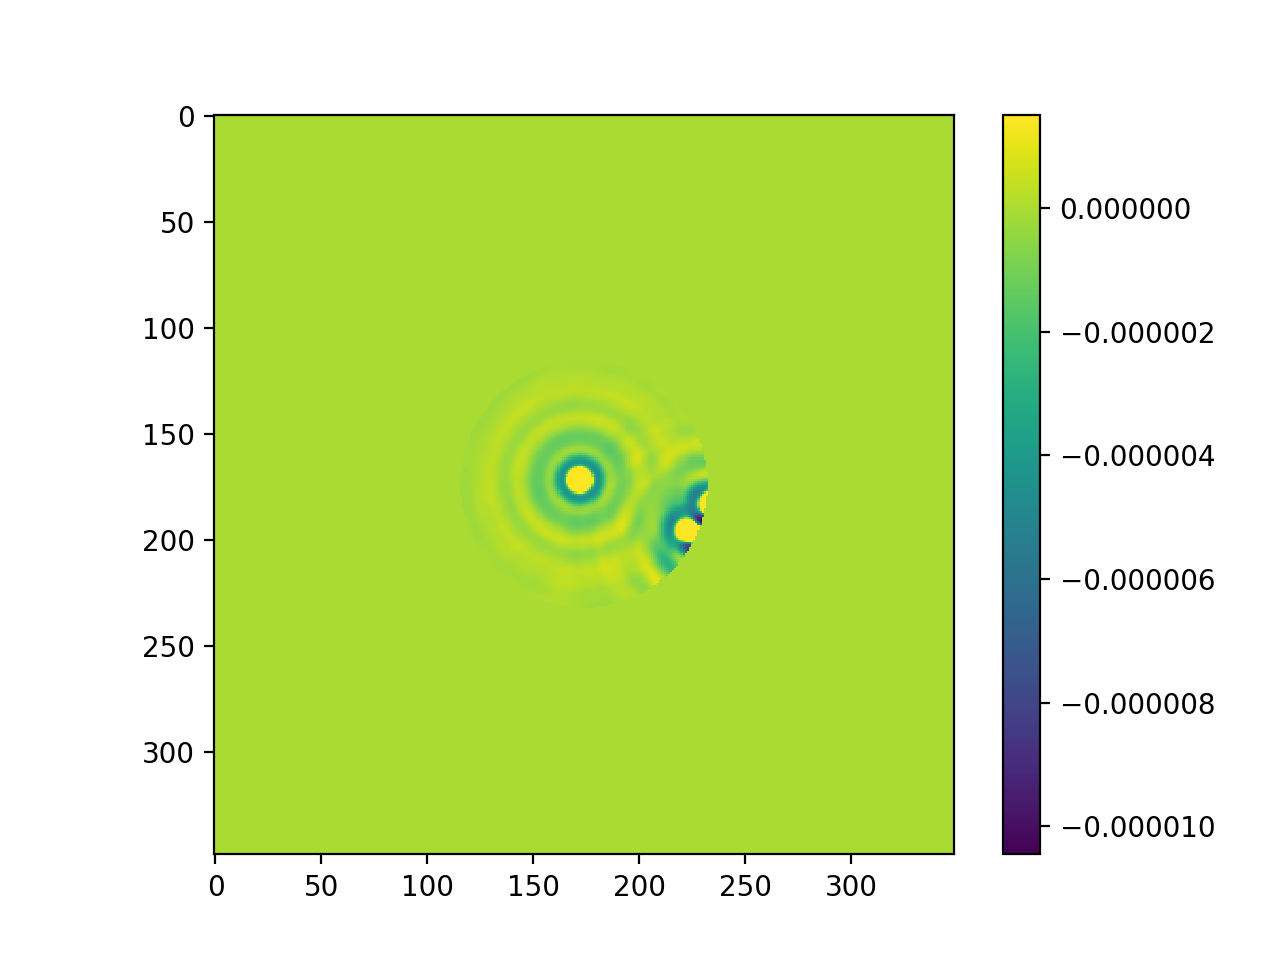

In [54]:
cmask=ymsr.gm.return_center_mask(100)
cm=(fdata-fdatar)-(fdata-fdatar)*(1-cmask)

figure()
imshow(cm,vmax=1.5e-6)
colorbar()

<IPython.core.display.Javascript object>


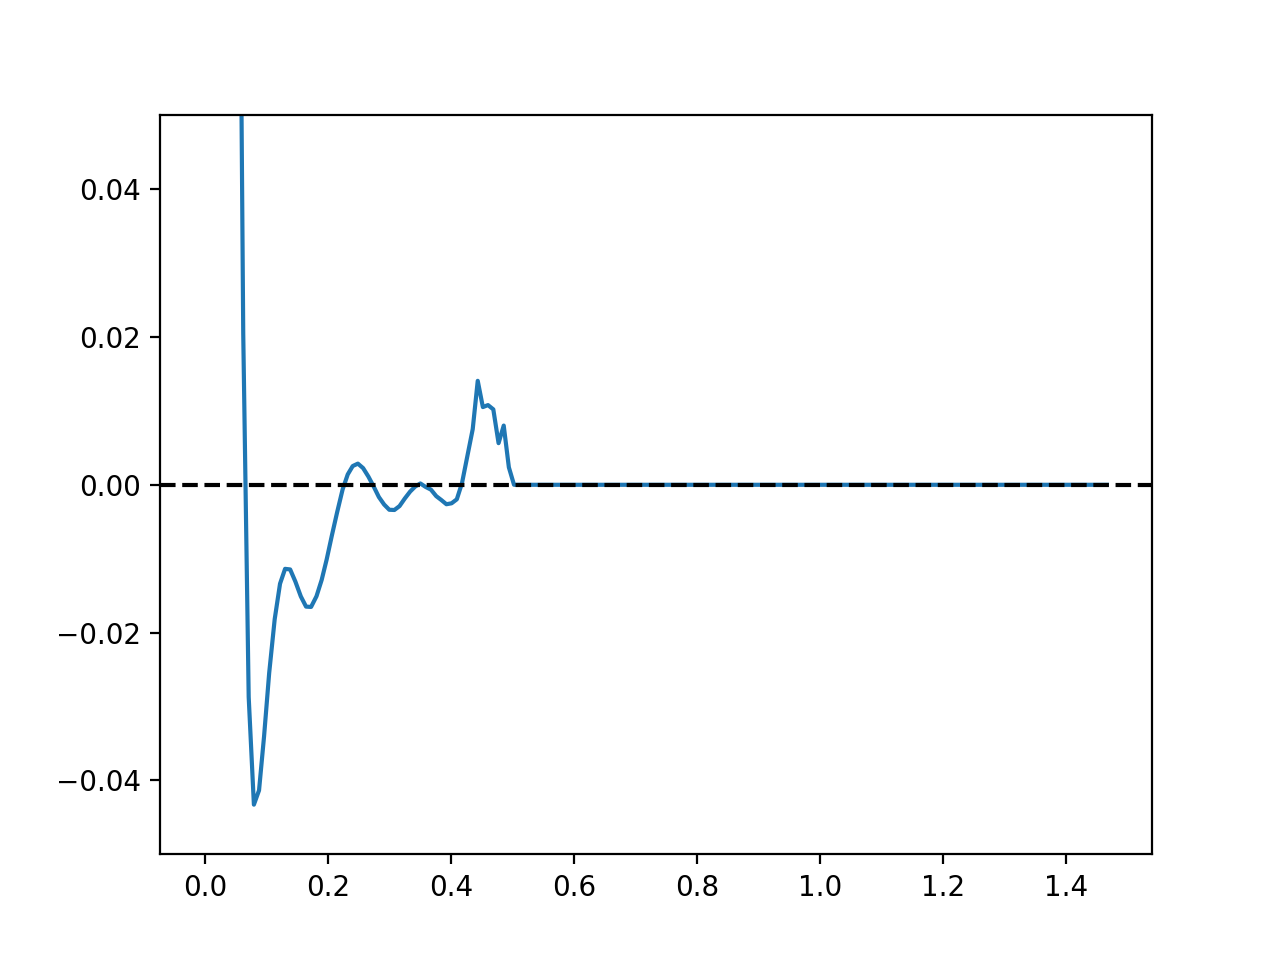

(-0.05, 0.05)

In [56]:
r,fr=ymsr.fsa.get_azi_avg(cm,pixel_size=gset.mmfset.reso)

figure()
plot(r*gset.mmfset.reso,fr/max(fr))
axhline(0,c="k",ls="--")
ylim(-0.05,0.05)

0.000117152894755 1.89800422803e-05


<IPython.core.display.Javascript object>


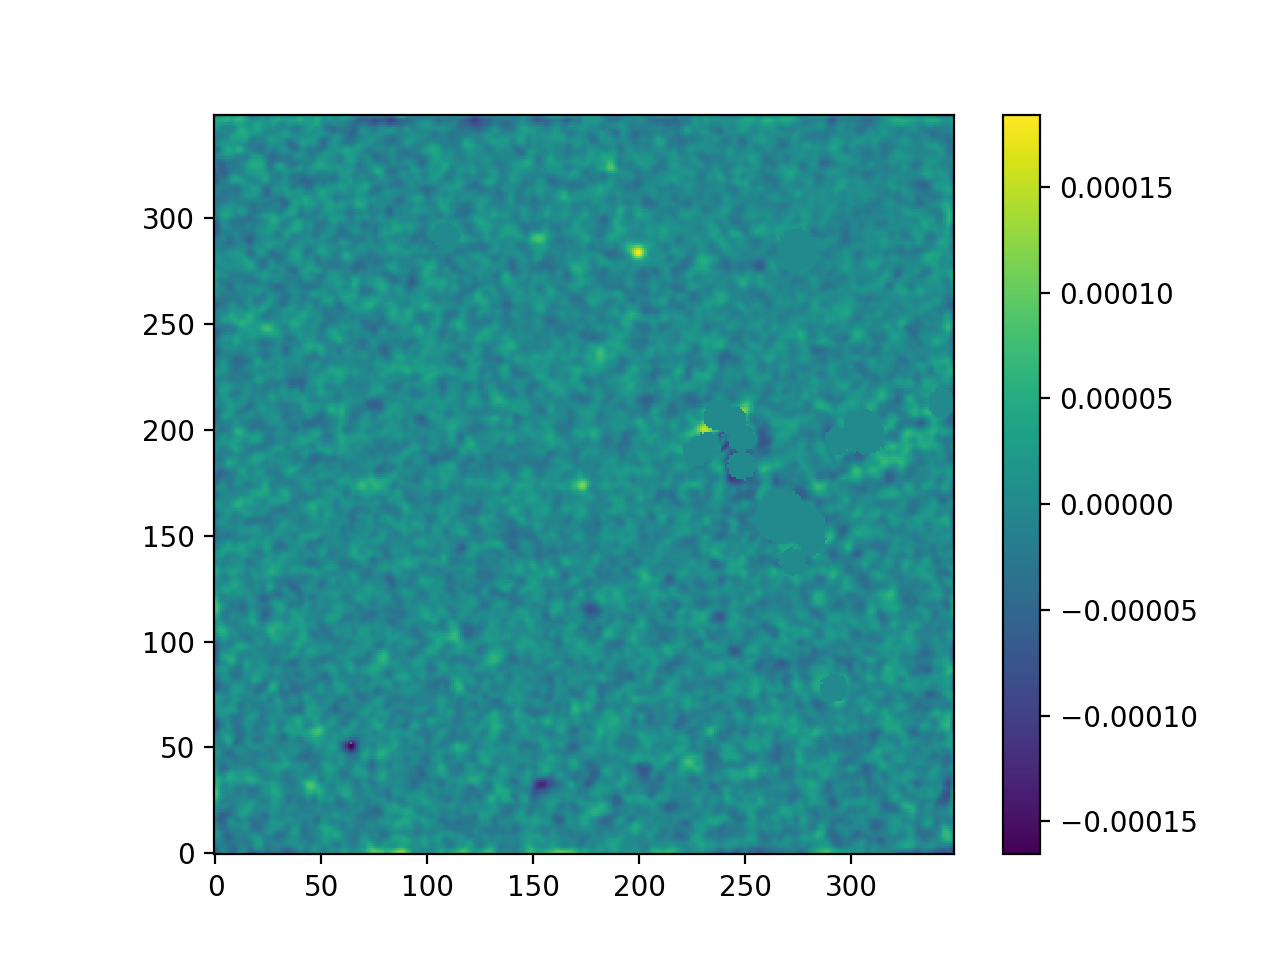

<IPython.core.display.Javascript object>


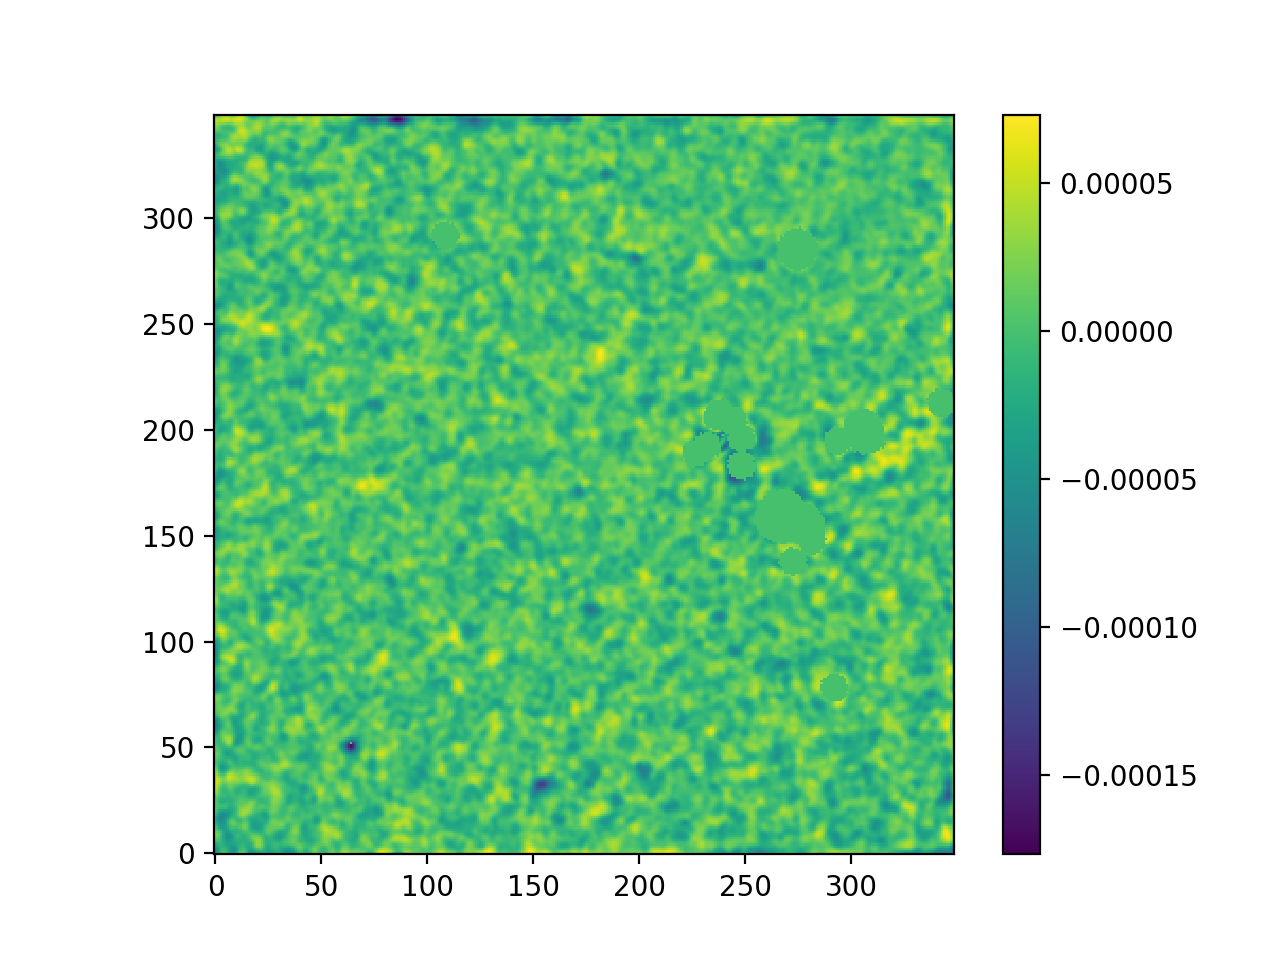

<IPython.core.display.Javascript object>


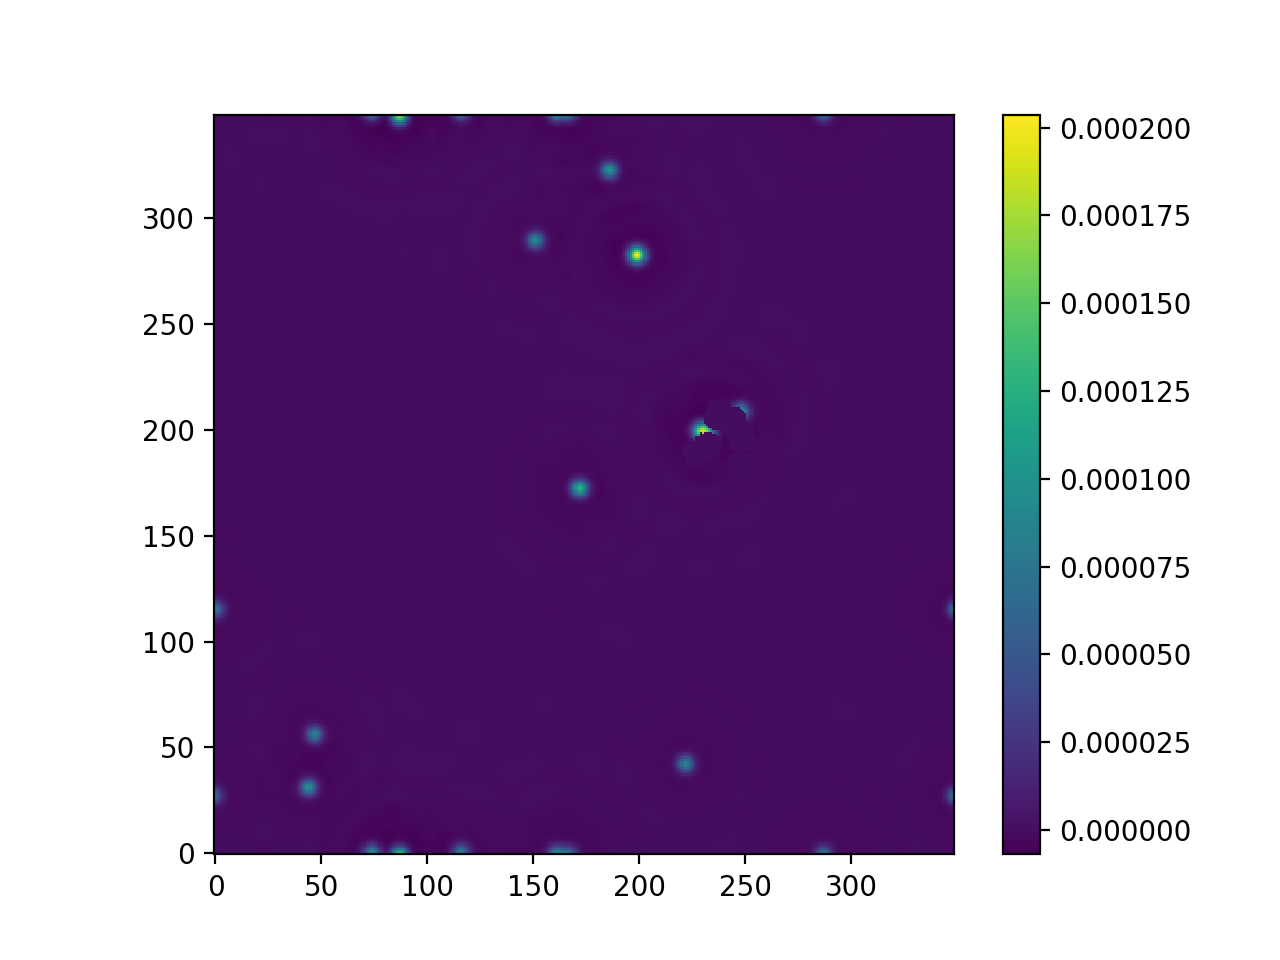

In [28]:
pmmf.emask[:,:]=1.
fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
print max((fdata*pmmf.cmask).ravel()),err

filename=xsz_cat["FILENAME"][idx]
mask=ymsr.gtp.return_ext_ps_mask(filename)

figure()
imshow(fdata*mask,origin="lower")
colorbar()

figure()
imshow(fdatar*mask,origin="lower")
colorbar()

figure()
imshow((fdata-fdatar)*mask,origin="lower")
colorbar()

In [36]:
cmask=ymsr.gm.return_center_mask(80)

<IPython.core.display.Javascript object>


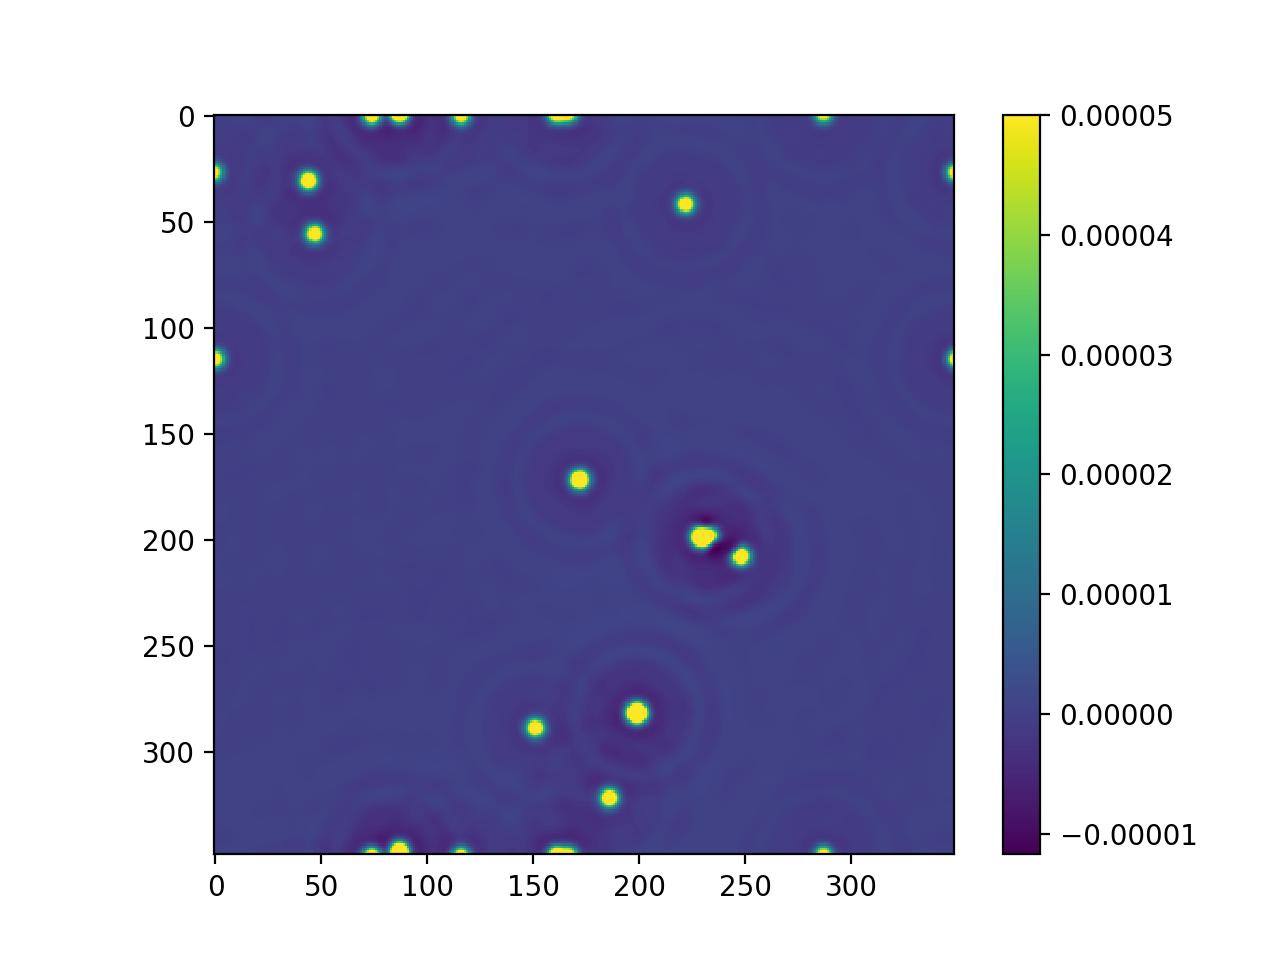

In [40]:
figure()
imshow((fdata-fdatar),vmax=5e-5)
colorbar()

In [69]:
template=pmmf.tmplt.gen_template(thetac=10.)
template_ft=ymsr.fsa.map2alm(template,pixel_size=gset.mmfset.reso)
elld=arange(6000) ; bl=np.ones_like(elld) ; bl[elld>1700]=0. ; bl[elld<400]=0.
lpfiltr=ymsr.fsa.get_fourier_filter(bl,gset.mmfset.npix,pixel_size=gset.mmfset.reso,ell=elld)
template353=ymsr.fsa.alm2map(template_ft*pmmf.tmplt.chfiltr[353.]*lpfiltr,pixel_size=gset.mmfset.reso)

<IPython.core.display.Javascript object>


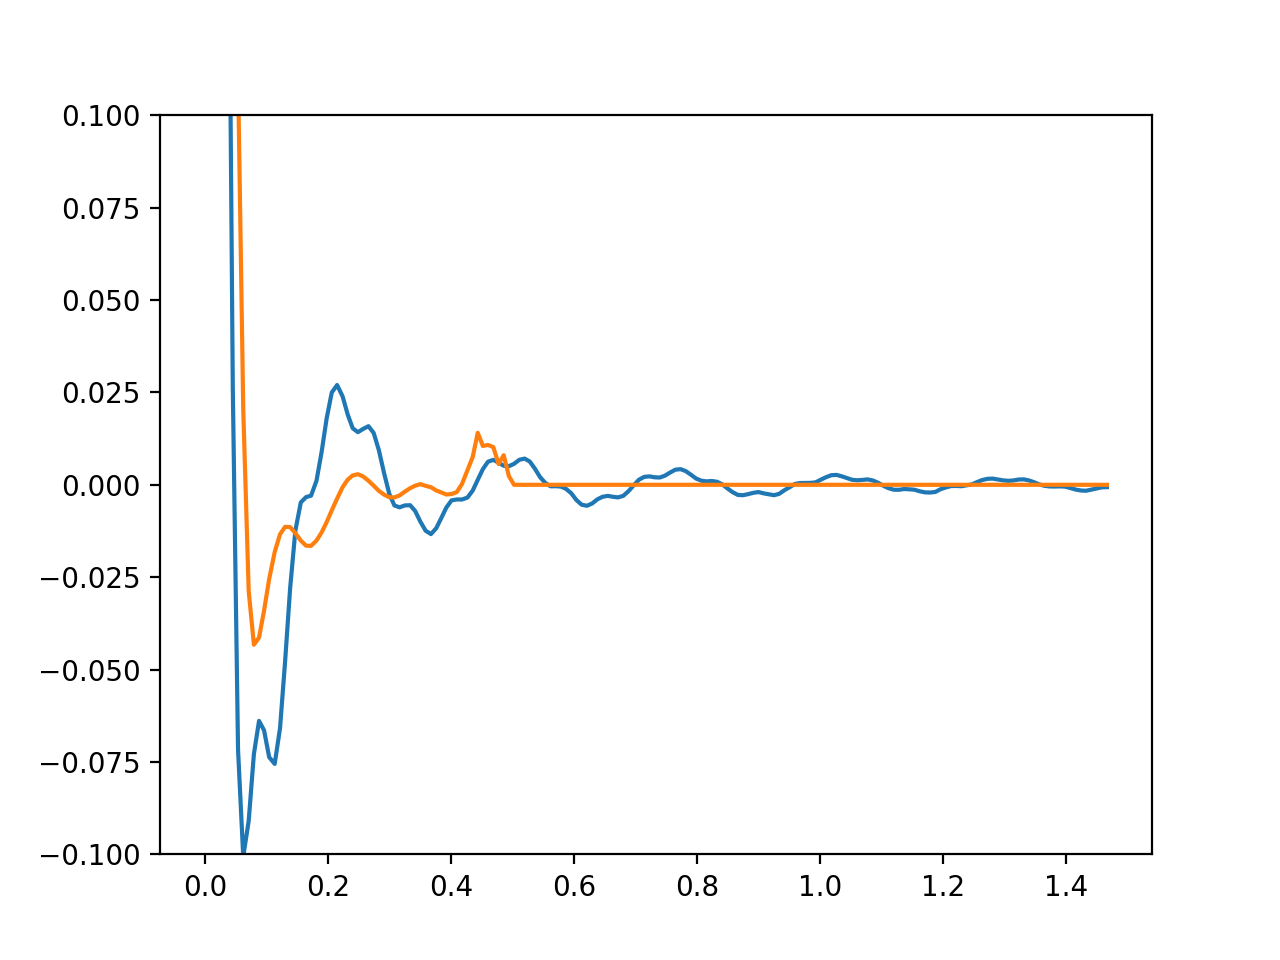

(-0.1, 0.1)

In [70]:
rt,frt=ymsr.fsa.get_azi_avg(template353,pixel_size=gset.mmfset.reso)
figure()
plot(rt*gset.mmfset.reso,frt/max(frt))
plot(r*gset.mmfset.reso,fr/max(fr))
ylim(-0.1,0.1)

<IPython.core.display.Javascript object>


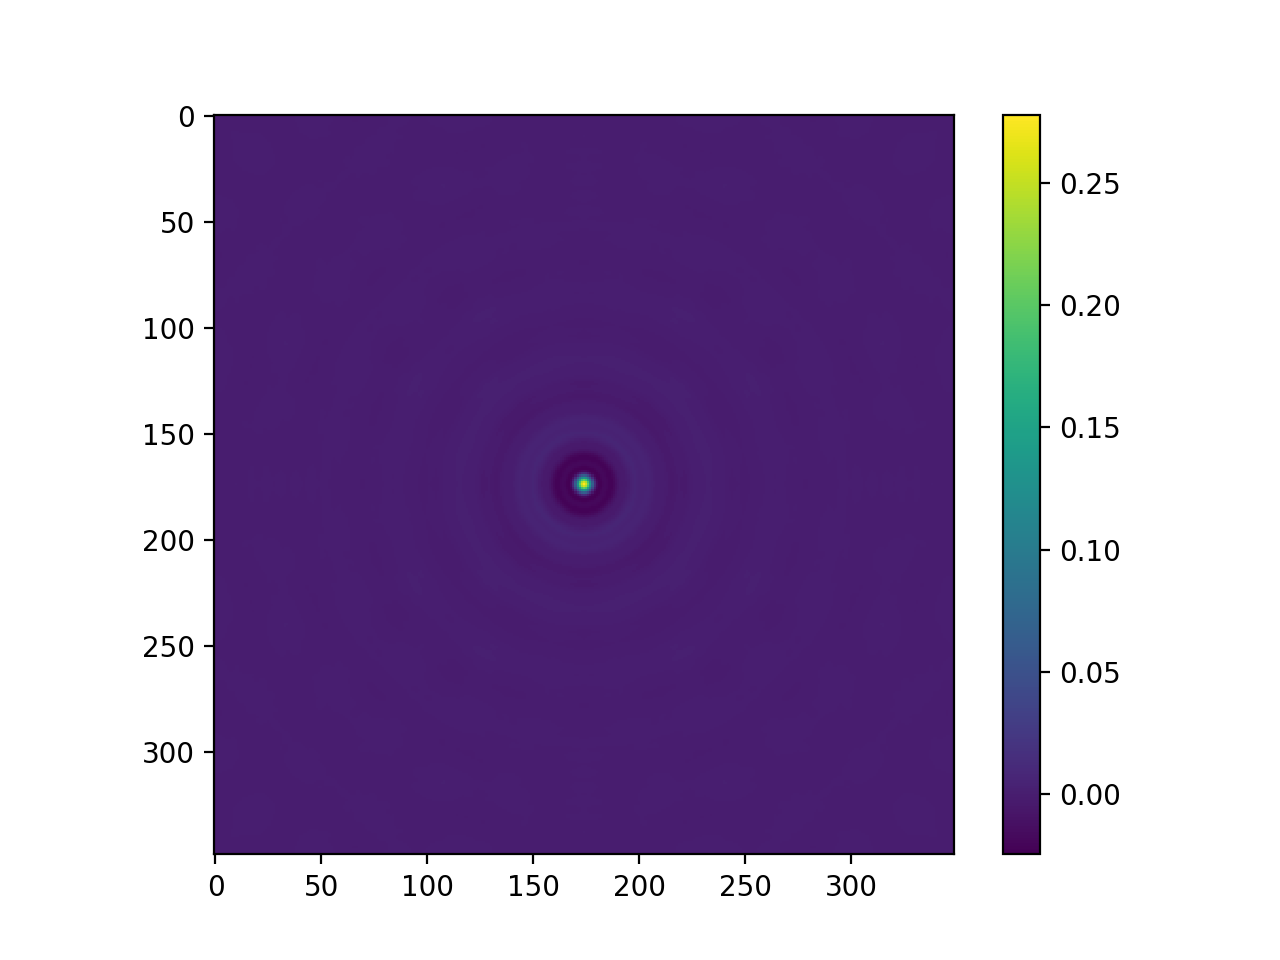

<IPython.core.display.Javascript object>


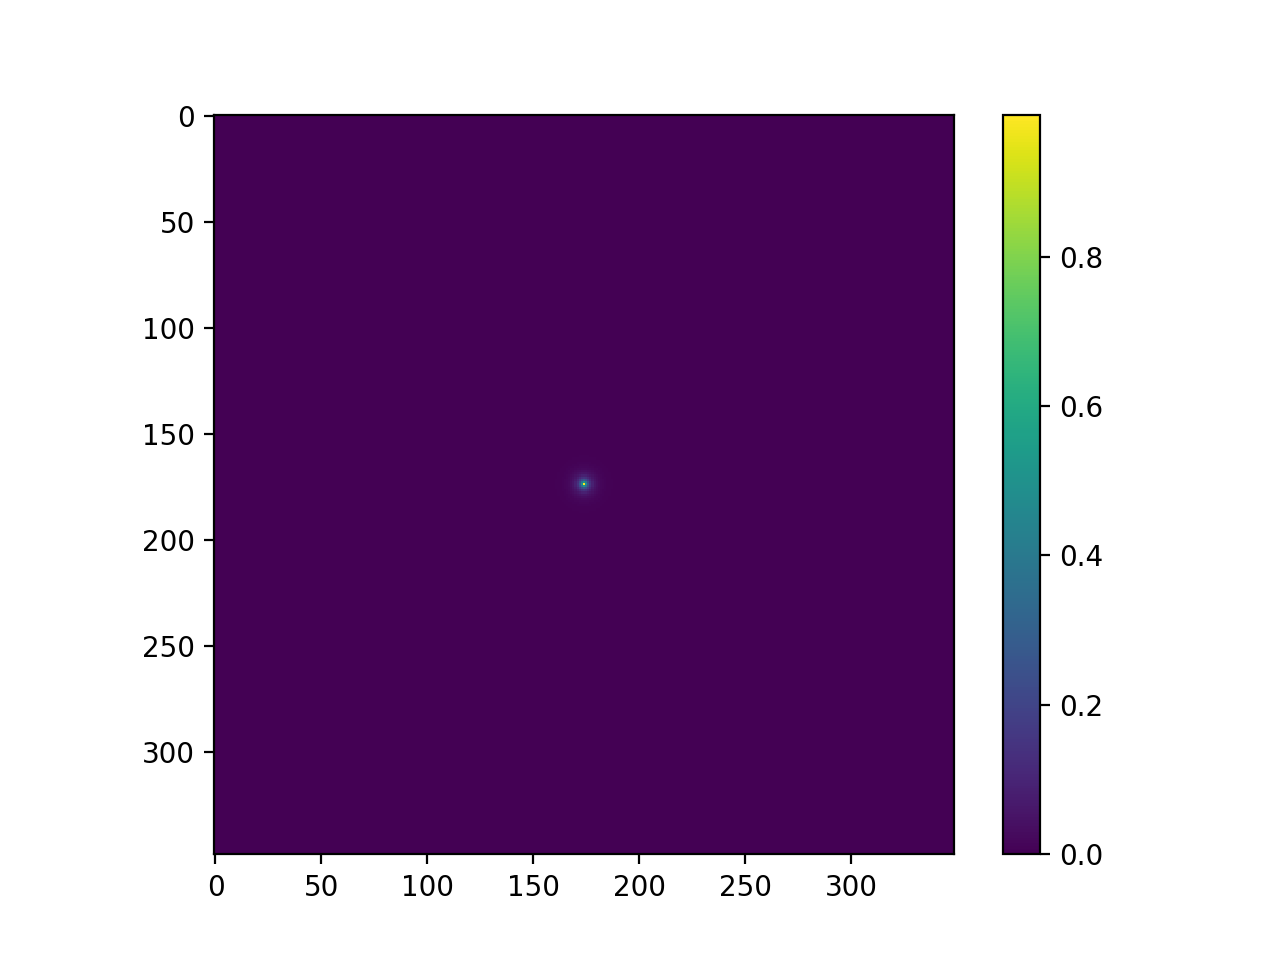

In [68]:
figure()
imshow(template353)
colorbar()

figure()
imshow(template)
colorbar()